# Proyek Klasifikasi Gambar: AnimeLens

## Import Semua Packages/Library yang Digunakan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import zipfile
import os
import shutil
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

## Data Preparation

### Data Loading

In [2]:
!pip install gdown

!gdown --folder https://drive.google.com/drive/folders/1UC9gmzoZDn_FNN8kbqc3eePJ4bOR4kyH?usp=sharing

Retrieving folder contents
Processing file 17JoLzVBDzE99EqhTGwH6O1q-KrNKiGHq AnimeLens.rar
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=17JoLzVBDzE99EqhTGwH6O1q-KrNKiGHq
From (redirected): https://drive.google.com/uc?id=17JoLzVBDzE99EqhTGwH6O1q-KrNKiGHq&confirm=t&uuid=72d0f040-263c-46ba-a151-173b6a1628db
To: /content/Capstone/AnimeLens.rar
100% 400M/400M [00:05<00:00, 68.6MB/s]
Download completed


In [3]:
!pip install rarfile

In [4]:
import rarfile
extract_dir = "/content/Capstone"
os.makedirs(extract_dir, exist_ok=True)

try:
    with rarfile.RarFile("/content/Capstone/AnimeLens.rar", 'r') as rar_ref:
        rar_ref.extractall(extract_dir)
    print(f"Successfully extracted /content/Capstone/AnimeLens.rar to {extract_dir}")
except rarfile.BadRarFile:
    print("Error: The file is not a valid RAR archive or is corrupted.")
except FileNotFoundError:
    print("Error: The file /content/Capstone/AnimeLens.rar was not found.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully extracted /content/Capstone/AnimeLens.rar to /content/Capstone


In [5]:
# Path ke folder utama dataset
Dataset_dir = '/content/Capstone/AnimeLens'

# Inisialisasi list untuk menyimpan informasi
file_name = []
labels = []
full_path = []
widths = []
heights = []
formats = []

# Looping melalui seluruh file di folder dan subfolder
for path, subdirs, files in os.walk(Dataset_dir):
    for name in files:
        file_path = os.path.join(path, name)

        try:
            with Image.open(file_path) as img:
                width, height = img.size
                fmt = img.format
        except:
            width, height, fmt = None, None, None

        # Simpan data
        full_path.append(file_path)
        file_name.append(name)
        labels.append(os.path.basename(path))
        widths.append(width)
        heights.append(height)
        formats.append(fmt)

# Membuat DataFrame
df = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels,
    "width": widths,
    "height": heights,
    "format": formats
})

# Tampilkan contoh
df.head()

,path,file_name,labels,width,height,format
0,"/content/Capstone/AnimeLens/Fireworks, Should ...","Fireworks, Should We See It from the Side or t...","Fireworks, Should We See It from the Side or t...",300,300,PNG
1,"/content/Capstone/AnimeLens/Fireworks, Should ...","Fireworks, Should We See It from the Side or t...","Fireworks, Should We See It from the Side or t...",300,300,PNG
2,"/content/Capstone/AnimeLens/Fireworks, Should ...","Fireworks, Should We See It from the Side or t...","Fireworks, Should We See It from the Side or t...",300,300,PNG
3,"/content/Capstone/AnimeLens/Fireworks, Should ...","Fireworks, Should We See It from the Side or t...","Fireworks, Should We See It from the Side or t...",300,300,PNG
4,"/content/Capstone/AnimeLens/Fireworks, Should ...","Fireworks, Should We See It from the Side or t...","Fireworks, Should We See It from the Side or t...",300,300,PNG


In [6]:
total_images = len(df)
print(f"Total Gambar: {total_images}")

Total Gambar: 3000


In [7]:
df['labels'].unique()

array(['Fireworks, Should We See It from the Side or the Bottom',
       'Hello World', 'The Garden of Words', 'Your Name', 'Summer Ghost',
       'Grave of the Fireflies', 'Josee, the Tiger and the Fish',
       'A Whisker Away', 'A Silent Voice', 'The Anthem of the Heart'],
      dtype=object)

<ipython-input-8-a3b979b4efa3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


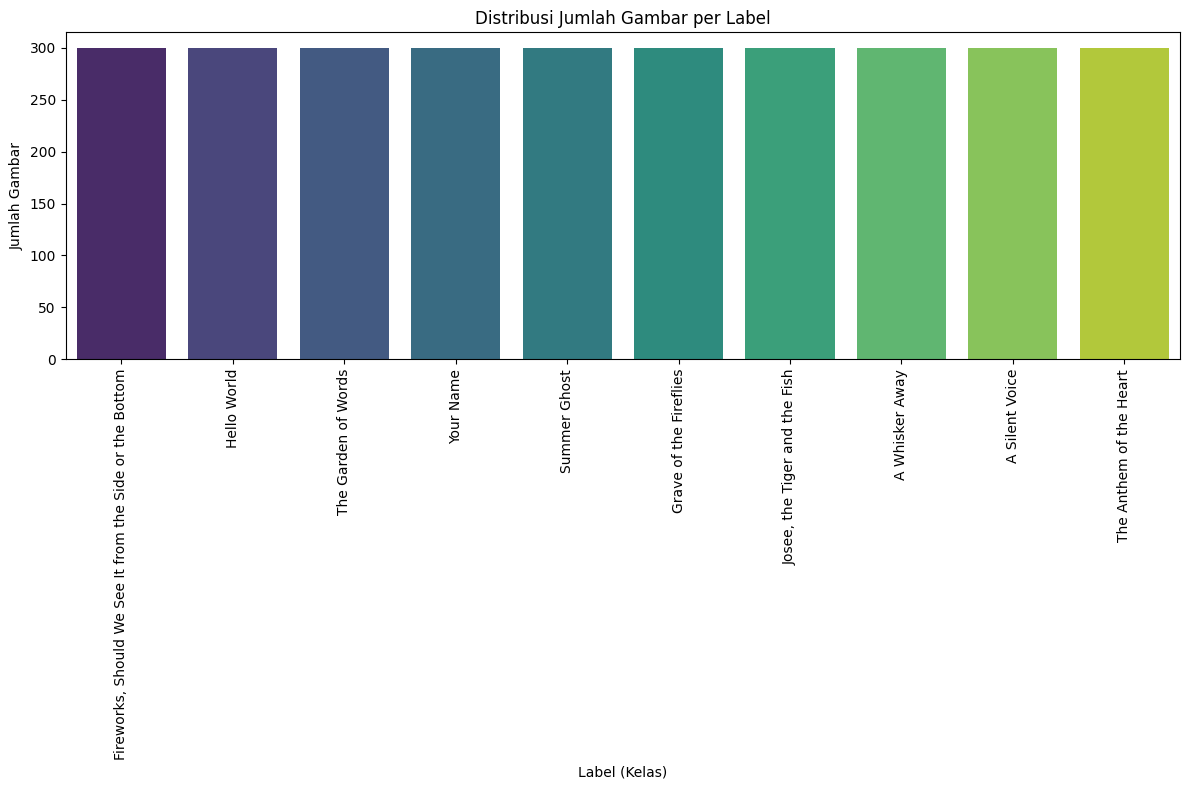

In [8]:
# Hitung jumlah gambar per label
label_counts = df['labels'].value_counts()

# Visualisasi bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title("Distribusi Jumlah Gambar per Label")
plt.xlabel("Label (Kelas)")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [9]:
def print_images_resolution(root_dir, allowed_ext={'.jpg', '.jpeg', '.png'}):
    total_images = 0

    for path, subdirs, files in os.walk(root_dir):
        image_files = [f for f in files if os.path.splitext(f)[1].lower() in allowed_ext]
        if not image_files:
            continue

        relative_folder = os.path.relpath(path, root_dir)
        print(f"{relative_folder}: {len(image_files)}")
        total_images += len(image_files)

        unique_sizes = set()

        for img_file in image_files:
            img_path = os.path.join(path, img_file)
            try:
                with Image.open(img_path) as img:
                    unique_sizes.add(img.size)
            except Exception as e:
                print(f"  Gagal membuka: {img_file} ({e})")

        for size in unique_sizes:
            print(f"  - Resolusi: {size}")
        print("---------------")

    print(f"Total semua gambar: {total_images}")

print_images_resolution('/content/Capstone/AnimeLens')

Fireworks, Should We See It from the Side or the Bottom: 300
  - Resolusi: (300, 300)
---------------
Hello World: 300
  - Resolusi: (300, 300)
---------------
The Garden of Words: 300
  - Resolusi: (300, 300)
---------------
Your Name: 300
  - Resolusi: (300, 300)
---------------
Summer Ghost: 300
  - Resolusi: (300, 300)
---------------
Grave of the Fireflies: 300
  - Resolusi: (300, 300)
---------------
Josee, the Tiger and the Fish: 300
  - Resolusi: (300, 300)
---------------
A Whisker Away: 300
  - Resolusi: (300, 300)
---------------
A Silent Voice: 300
  - Resolusi: (300, 300)
---------------
The Anthem of the Heart: 300
  - Resolusi: (300, 300)
---------------
Total semua gambar: 3000


### Data Preprocessing

#### Split Dataset

In [10]:
def split_dataset_train_test(source_dir, output_dir, train_ratio=0.90, seed=42):
    random.seed(seed)

    # Buat folder output train & test
    for split in ['train', 'test']:
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        n_total = len(images)
        n_train = int(train_ratio * n_total)
        splits = {
            'train': images[:n_train],
            'test': images[n_train:]
        }

        for split, img_list in splits.items():
            split_class_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)

            for img_file in img_list:
                src = os.path.join(class_path, img_file)
                dst = os.path.join(split_class_dir, img_file)
                shutil.copy2(src, dst)

        print(f"{class_name}: {n_total} → train: {n_train}, test: {n_total - n_train}")

    print("Dataset berhasil di-split ke dalam train dan test.")

In [11]:
split_dataset_train_test(
    source_dir="/content/Capstone/AnimeLens",
    output_dir="/content/split_dataset",
    train_ratio=0.90
)

Fireworks, Should We See It from the Side or the Bottom: 300 → train: 270, test: 30
Hello World: 300 → train: 270, test: 30
The Garden of Words: 300 → train: 270, test: 30
Your Name: 300 → train: 270, test: 30
Summer Ghost: 300 → train: 270, test: 30
Grave of the Fireflies: 300 → train: 270, test: 30
Josee, the Tiger and the Fish: 300 → train: 270, test: 30
A Whisker Away: 300 → train: 270, test: 30
A Silent Voice: 300 → train: 270, test: 30
The Anthem of the Heart: 300 → train: 270, test: 30
Dataset berhasil di-split ke dalam train dan test.


In [12]:
def df_split_dataset(base_path):
    data = []
    for split in ['train', 'test']:
        split_path = os.path.join(base_path, split)
        for class_name in os.listdir(split_path):
            class_dir = os.path.join(split_path, class_name)
            if os.path.isdir(class_dir):
                for file_name in os.listdir(class_dir):
                    if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        file_path = os.path.join(class_dir, file_name)
                        data.append({
                            'path': file_path,
                            'file_name': file_name,
                            'label': class_name,
                        })

    return pd.DataFrame(data)

df_split = df_split_dataset("/content/split_dataset")
print(df_split.head())

                                                path  \
0  /content/split_dataset/train/Fireworks, Should...   
1  /content/split_dataset/train/Fireworks, Should...   
2  /content/split_dataset/train/Fireworks, Should...   
3  /content/split_dataset/train/Fireworks, Should...   
4  /content/split_dataset/train/Fireworks, Should...   

                                           file_name  \
0  Fireworks, Should We See It from the Side or t...   
1  Fireworks, Should We See It from the Side or t...   
2  Fireworks, Should We See It from the Side or t...   
3  Fireworks, Should We See It from the Side or t...   
4  Fireworks, Should We See It from the Side or t...   

                                               label  
0  Fireworks, Should We See It from the Side or t...  
1  Fireworks, Should We See It from the Side or t...  
2  Fireworks, Should We See It from the Side or t...  
3  Fireworks, Should We See It from the Side or t...  
4  Fireworks, Should We See It from the Side or t..

In [13]:
df_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   path       3000 non-null   object
 1   file_name  3000 non-null   object
 2   label      3000 non-null   object
dtypes: object(3)
memory usage: 70.4+ KB


In [14]:
# Parameter dataset
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS = 50

In [15]:
training_path = "/content/split_dataset/train"
testing_path = "/content/split_dataset/test"

img_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    validation_split=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

train_generator = img_gen.flow_from_directory(
    training_path,
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = img_gen.flow_from_directory(
    training_path,
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = img_gen.flow_from_directory(
    testing_path,
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    shuffle=False
)

Found 2160 images belonging to 10 classes.
Found 540 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


## Modelling

In [16]:
def create_mobilenetv2_model():
    """
    Membangun model MobileNetV2 dengan transfer learning
    """
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model, base_model

model, base_model = create_mobilenetv2_model()

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [17]:
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.97 and logs.get('val_accuracy') > 0.97:
            print("\nAkurasi pelatihan dan validasi telah mencapai >97%! Pelatihan dihentikan.")
            self.model.stop_training = True

class EarlyStoppingAlert(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            print(f"\nEarly stopping triggered at epoch {epoch + 1}")

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callback_list = [
    myCallback(),
    EarlyStoppingAlert(),
    early_stopping,
    reduce_lr,
]

In [18]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callback_list,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 72s 862ms/step - accuracy: 0.1626 - loss: 2.4995 - val_accuracy: 0.3500 - val_loss: 1.8073 - learning_rate: 0.0010
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 47s 692ms/step - accuracy: 0.3563 - loss: 1.8298 - val_accuracy: 0.4574 - val_loss: 1.5024 - learning_rate: 0.0010
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 45s 663ms/step - accuracy: 0.4517 - loss: 1.5417 - val_accuracy: 0.5019 - val_loss: 1.3846 - learning_rate: 0.0010
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 47s 687ms/step - accuracy: 0.4932 - loss: 1.4630 - val_accuracy: 0.5259 - val_loss: 1.3361 - learning_rate: 0.0010
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 47s 691ms/step - accuracy: 0.5179 - loss: 1.3545 - val_accuracy: 0.5556 - val_loss: 1.2659 - learning_rate: 0.0010
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 47s 689ms/step - accuracy: 0.5723 - loss: 1.2264 - val_accuracy: 0.5667 - val_loss: 1.2482 - learning_rate: 0.0010
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 46s 677ms/step - accuracy: 0.5721 - loss: 1.

## Evaluasi dan Visualisasi

10/10 - 8s - 823ms/step - accuracy: 0.6767 - loss: 0.9586

Test accuracy: 0.6766666769981384


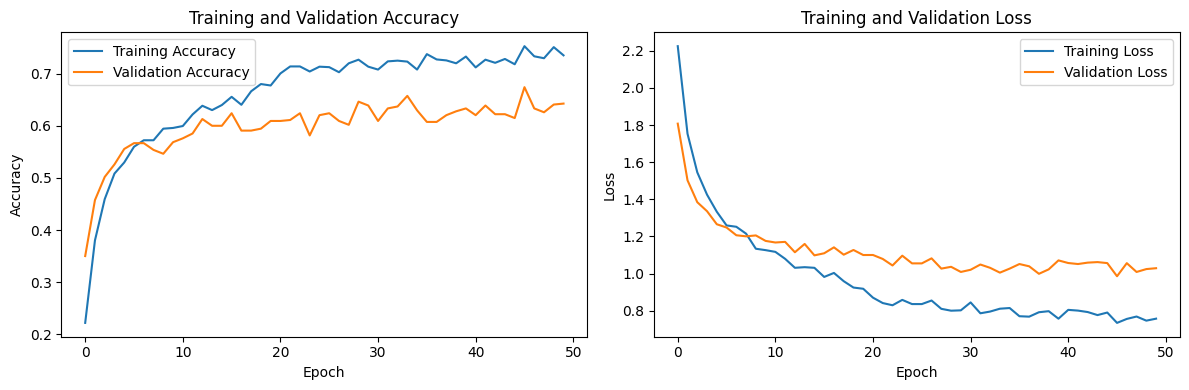

In [19]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)

# Plotting the training and validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
save_path = 'saved_model/'
tf.saved_model.save(model, save_path)

In [21]:
model.save('animelens_model.h5')

## Konversi Model

In [22]:
# Convert to TFJS
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [23]:
!tensorflowjs_converter --input_format=tf_saved_model saved_model/ ./tfjs_model

2025-06-04 09:43:58.219052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749030238.240315   13775 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749030238.246507   13775 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-06-04 09:44:06.290552: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1749030246.290758   13775 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## Inference (Optional)

In [ ]:
import zipfile

def zip_folders(folder_paths, zip_filename):
  with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for folder_path in folder_paths:
      for root, _, files in os.walk(folder_path):
        for file in files:
          file_path = os.path.join(root, file)
          zipf.write(file_path, arcname=os.path.relpath(file_path, folder_path))

# Example usage:
zip_folders(['/content/split_dataset'], 'split.zip')

In [25]:
def zip_folders(folder_paths, zip_filename):
  with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for folder_path in folder_paths:
      for root, _, files in os.walk(folder_path):
        for file in files:
          file_path = os.path.join(root, file)
          zipf.write(file_path, arcname=os.path.relpath(file_path, folder_path))

# Example usage:
zip_folders(['/content/saved_model'], 'model.zip')

In [24]:
def zip_folders(folder_paths, zip_filename):
  with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for folder_path in folder_paths:
      for root, _, files in os.walk(folder_path):
        for file in files:
          file_path = os.path.join(root, file)
          zipf.write(file_path, arcname=os.path.relpath(file_path, folder_path))

zip_folders(['/content/tfjs_model'], 'tfjs_model.zip')
